
## CQF Final Project: Long/Short Trading Strategy Design & Backtest
### Alexys Pereira

### Introduction

This project is focused on implementing a Long/Short trading strategy designed using statistical analysis. This trading strategy consists on evaluating if a pair of assets that economically share similarities has constant spread i.e. if the difference between the prices of these two assets have constant mean and variance through time. <br>
This price difference is named as spread, and we can evaluate if this difference has constant first and second moments through cointegration analysis. <br>
Three pairs of assets will be studied:
1. **Royal Bank of Canada (RBC Bank) and Toronto-Dominion Bank (TD)**: these are the two largest Canadian banks and both are classified as G-SIBs, furthermore due to the market concentration in Canada's banking system, it is intuitive that these two assets have constant spread due to the similar nature of their business i.e. both are large and ultimately one can replace the other from an investor perspective.
2. **Japanese Yen (JPYUSD) and Gold Future (GC)**: there is a known relationship between those two assets that they are usually considered as safe-havens in periods of crisis due to stability of Japanese economy and Gold being a physical assets
3. **Canadian Dollar (CADUSD) and Oil Future**: Canada is one of the largest producers of oil in world and its currency has been observed to follow Oil prices fairly closely as oil is a large component of the country's economy, hence by evaluating if cointegration exists we can exploit any potential deviation for profits
<br>

A large component of the project is the implementation of numerical procedures from first principles, the list below shows the procedures implemented by the autor:
- **Ordinary Least Squares Regression (OLS) in Matrix Format**: coefficient estimation, standard error and p-value calculation, AIC and BIC calculations.
- **Augmented-Dickey Fuller Test**: equation specification, optimal lag selection and reject/accept decision - Mackinnon T-statistic and p-value calculation were used from statsmodels package since it was not covered in the course
- **Error Correction Model**
- **Ornstein-Uhlenbeck Process fitting**
- **Engle-Granger cointegration procedure**
- **Backtesting and risk assessment framework**: 
    - Signal Generation
    - P&L Computation
    - Rolling Alpha, Beta and Sharpe Ratios
    - Drawdown, VaR and ES calculation

### Methodology

#### Cointegration parameter estimation: Engle-Granger Procedure
The methodology adopted for this Long/Short trading strategy design in based on pairs cointegration procedure  Engle-Granger procedure to determine if two series are cointegrated.<br>
Two series are said to be cointegrated if a linear combination between them is stationary, mathematically this can be expressed as:

$$ Z_t = Y_t - \hat\beta X_t - c $$ If $ Z_t $ is stationary then $X$ and $Y$ are said to be cointegrated. Note that variable $Z$ in fact is the residual from the Ordinary Least Square Regression of  $Y$ on $X$.<br>

The Engle-Granger procedures has three main steps: <br>
**1.** Estimate a linear regression of $Y$ on $X$ via OLS to extract the linear combination between the two series, which is given by the vector $ [1, -\hat\beta] $
<br>
**2.** Test if the residual $Z$ is a stationary using the Augmented Dickey Fuller Test (ADF) without trend term <br>
The ADF test consists in determining if the given series Z has a unit-root i.e. if it is mean-reverting, this means that the level of $Z_t$ can predict the change in $\Delta Z_t$ therefore mean-reversion exists.
<br> Mathematically we define the test as an autoregression via OLS of $\Delta Z_t$ on its lagged level and differences i.e.

$$ \Delta Z_t = (\rho-1)Z_{t-1} + \sum_{k=0}^{k=K}{\phi_k \Delta Z_{t-k}} + \alpha + \epsilon_t $$

$$ H_0: \rho - 1 =0 \ has \ Unit\ Root \\
 H_1: \rho - 1 \neq 0 $$



**3.** Fit an Error Correction Model via Linear Regression with the following specification: 
$$ \Delta Y_t = \phi \Delta X_t - (1- \alpha)Z_{t-1} $$ 
<br> The Error Correction portion is the lagged residual $Z_{t-1}$ and its coefficient $(1-\alpha)$ must the statistically significant
<br>

If residual $Z$ is stationary (2) and the error correction coefficient is statistically significant (3), hence we can say that series $X$ and $Y$ are cointegrated and that there is an underlying factor between them that makes their spread revert to its mean

The Engle-Granger procedure is compute in both direction i.e. $ Y_t = \hat\beta X_t + c $ and $ X_t = \hat\beta Y_t + c $ <br>
**The direction that is selected to produce the trades is the one that has the highest absolute T-Statistic vakyes in the ADF test**


#### Assessment of quality of mean reversion: Ornstein-Uhlenbeck process
<br>
After confirming that two securities are indeed cointegrated i.e. there is mean-reverting difference between their prices (spread), we can design trades based on this mean reversion by estimating the parameters of the Ornstein-Uhlenbeck (OU) stochastic process.<br>
Estimating this process provides two main insights:
<br>a) The speed of the mean-reversion or its half-life: measurement in days of how long does it take for the spread/residual to return to its long-term mean
<br>b) Entry and exit points of the position by measuring the diffusion (standard deviation) of the OU process: with this estimate we can determine what is the proper time to enter a position.

<br> The OU process consisting in solving the following Stochastic Differential Equation (SDE):

$$ de_t = -\theta (e_t - \mu_e)dt + \sigma_{OU}dX_t $$
<br>
SDE Solution: $$  e_{t+\tau} = (1 - e^{-\theta \tau})\mu_e + e^{\theta \tau}e_t + \epsilon_{t,\tau}$$
<br>
But we are interested in the parameters $\theta$ and $\mu_e$ because they refer to mean-reversion speed and equilibrium spread<br> To extract these parameters we can simply fit an AR(1) via OLS on the spread estimated via Cointegration, mathematically we compute the spread as $$ e_t = Y_t - \hat\beta X_t - \epsilon_t $$ <br> And then using the output of this regression, we fit the following AR(1) process: $$ e_t = Be_{t-1} + C $$<br>
Hence, $$ B = e^{-\theta \tau} \Rightarrow \theta = - \frac{\ln B}{\tau} $$
$$ C = (1 - e^{-\theta \tau})\mu_e \Rightarrow \mu_e =  \frac{C}{1-B} $$
<br>Finally the last parameters are the standard error of the equation that will be used for determining the upper and lower bounds
<br>
$$ \sigma_{eq} = \sqrt{ \frac{SSE \ \tau}{1-e^{-2\theta\tau}}} $$ 

And also the Half-life, which measures on average how long does it take for the spread to return to its equilibrium level $\mu_e$

$$ Half-life = \frac{\ln2}{\theta}$$

#### Trade Design

The trade strategy consisting in going long and short in each of series that are part of the cointegrated pair. There are three main decisions that need to be taken before doing the trade
1. Which security to short and which to go long?
2. How much of my capital my capital should I invest in each asset?
3. When should I enter and exit the trade?

To answer each of these questions we need to first define the upper/lower trading bounds: 
$$ Upper \ Bound = \mu_e + Z\sigma_{eq}$$ $$  Lower Bound = \mu_e - Z\sigma_{eq} $$

The bounds are symmetrical around the equilibrium point and are $Z \sigma_{eq}$ distant from it. This means that if the spread is greater than the Upper Bound or lower than the Lower Bound we start a trade, hence a signal is generated. <br>
If the spread is greater than the Upper Bound, this means that there is a tendency for the spread to return back to its equilibrium, hence we should short asset Y (the dependent variable on the regression) and go long $ \hat\beta$ units of asset X. <br>
But if spread is lower than the Lower Bound then there is a tendency for the spread to increase i.e $Y - \hat\beta X$ is increasing there fore we go long on Y and short  $ \hat\beta$ X.
<br> Mathematically:
<br>  $$ If \ Spread_t >  Upper \ Bound = \mu_e + Z\sigma_{eq} \Rightarrow Weights = [-100\% Y, \% \hat\beta X]$$
<br>  $$ If \ Spread_t <  Lower \ Bound = \mu_e - Z\sigma_{eq} \Rightarrow Weights = [100\% Y, -\% \hat\beta X]$$
<br>  $$ Exit \ Position \ when \ Spread_t \approx \mu_e$$


<br> Finally we exit our position when the spread is close to the equilibrium level $\mu_e$
<br> Because there is a hyperparameter Z involved in this trade design, the optimal threshold level will be determined by testing different levels of Z and the one selected will be the one the provides the best out-of-sample performance in terms of Alpha and Sharpe Ratio. In total, 7 values for Z will be explored [0.2, 0.3, 0.4, 0.5, 0.6, 0.7] - we want tight spreads to generate a higher number of trades over a period of time, otherwise there will be few trades and as time passes the estimated equilibrium might shift.

#### Performance Measurement

To assess the optimal Z level to start trades I will several risk-return and P&L metrics, both for the whole period as well as their six-month rolling measurement. The reason for that being that by computing rolling metrics we can assess how volatile the strategy is through time, theoretically they should be fairly stable because long/short strategy such as pairs trading are not directional.
<br>
The following metrics will be used to assess strategy performance:
- Cumulative and Annualized Return
- Cumulative and Annualized Volatility
- Annualized Alpha and Beta
- Six-month rolling and average Sharpe Ratio
- Six-month rolling and average Alpha
- Six-month rolling and average Beta
- Maximum Drawdown 
- Six-month rolling and average 10-day VaR 99%

#### Data preprocessing

The preprocessing of the time-series will be minimal limited to:
- Filling null values with  previous value (forward filling)
- Price normalization such that the prices such that all start at one. This manipulation is useful because addresses difference in scales between the securities and has the intuition that if I were to invest one dollar in each security how much I would earn, hence because the trading weights will be based on the coefficients then we can apply directly to build the portfolio 




#### Data and Backtesting/Validation Strategy

The data utilized is daily market prices extracted from Yahoo Finance using the pandas_datareader package between Jan 1st, 2010 and Feb 1st, 2020. This period has been selected as it was not affected by the Great Financial Crisis, COVID-19 Pandemic nor Russia-Ukraine war, this is important because cointegration are long-term trends and these events breakdown these patterns since the trade strategy assumes that these relationship will be stable moving forward. In other words, the mean-reversion properties change because correlation between assets increase such that it does not mean-reverts and the equilibrium $\mu_e$ itself changes. <br>
The second points refers to backtesting/validation strategy: I have decided to follow to divide the data into three smaller data sets
- **Training Set - Jan 1st, 2010 to Dec 31st, 2016:** this period will be used to estimate all the relevant parameters that will be used to design trades in the following periods
- **Validation Set - Feb 1st, 2017 to Feb 1st, 2019:** the validation set serves to evaluate the model out-of-sample performance to select the optimal strategy (optimal Z) such that maximizes Alpha and Sharpe Ratio
- **Test set - Mar 1st, 2010 to Feb 1st, 2020:** the gold standard where the results are in fact report if the strategy designed behaves as expected (or not and why).

Note that between each data set there is a one-month gap to minimize data leakage in order to maintain fairness.


### Implementation and Results

In [1]:
import os
import sys
sys.path.append(os.getcwd())
from pairs_trading import PairTradingBacktest,TradeAnalyzer
from cointegration import OLS, ADF, EngleGranger

import glob
import warnings 
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas_datareader.data as web
import itertools
import datetime as dt
from collections import Counter
from sklearn.linear_model import LinearRegression
from scipy import stats
pd.set_option("display.max_column",999)


styles = [dict(selector="caption", props=[("font-size", "120%"),
                                          ("font-weight", "bold"),("color","black")])]

In [2]:
def compute_risk_metrics(backtest_tbl,mkt_ticker = "SPY",historical_tbl=None):
   
    trade_analysis=[]
    for i, g in backtest_tbl.groupby("bounds_id"):
        historical_series = historical_tbl.query(f"bounds_id=={i}").set_index("day")['trade_daily_return'].dropna() if historical_tbl is not None else historical_tbl
        bounds_id = g.bounds_id.max()
        zscore=g.zscore.max()
        return_series = g['trade_daily_return'].copy()
        return_series.index=g.day
        return_series=return_series[return_series.notnull()]    
        analyzer = TradeAnalyzer(return_series, mkt_ticker,historical_returns=historical_series)
        analyzer.generate_analysis()
        analyzer.summary_table()   
        trade_analysis.append([bounds_id,zscore,analyzer])
    summary = pd.concat([ a.summary_table().assign(strategy_id=b, zscore=z) for b,z,a in trade_analysis])
    summary.head()
    summary['Strategy']="Z-Score = " + summary.zscore.astype(str)
    summary= summary.pivot(columns='Strategy',values=['Value (%)'],index='Metric')
    summary=summary.reindex(index=['Annual Return',
                                   'Annual Vol',
                                   'Cumulative Return',
                                   'Alpha (Annual)',
                                   'Sharpe','Beta',
                                   'Beta P-Value',
                                   'Alpha P-Value',
                                   'Max Drawdown',
                                   '1-Day VaR 99%',
                                   '10-Day VaR 99%',
                                   '1-Day ES 99%',
                                   '10-Day ES 99%',])
    
    trade_analysis=pd.DataFrame(trade_analysis,columns=['bounds_id','zscore','analyzer'])
    return summary,trade_analysis

In [3]:
tickers= [
            'CADUSD=X',
            'BZ=F',
            'RY.TO',
            'TD.TO',
            "JPYUSD=X",
            'GC=F',        

]


labels_ticker = ['CAD/USD', 
                 'Crude Oil Future',
                 'RBC',
                 'TD Bank',
                 'JPY/USD',
                 'Gold Futures',
                ]

pairs =[
        ['RY.TO','TD.TO'],
        ['CADUSD=X','BZ=F',],
        ["JPYUSD=X",'GC=F'],
       ]



In [4]:
labels_ticker = dict(zip(tickers,labels_ticker))


In [5]:
data = web.DataReader(tickers,'yahoo',start= '2010-01-01', end='2022-06-30')
data = data['Adj Close'].reset_index()

In [7]:
data.to_csv("data.csv",index=False)

With the data extracted and methodology laid out, we can proceed to the implementation and results cointegration for pairs tradings.<br>
We start by depicting in **Table 1** a small sample of the data set with prices normalized such that the initial point equals 1.

In [61]:
data = data.fillna(method='ffill').dropna()
data.head().style.set_caption("Table 1: Sample Data Used").set_table_styles(styles)

Symbols,Date,CADUSD=X,BZ=F,RY.TO,TD.TO,JPYUSD=X,GC=F
1,2008-01-02 00:00:00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,2008-01-03 00:00:00,1.005663,0.997547,0.991036,0.994421,0.997745,1.010969
3,2008-01-04 00:00:00,0.995595,0.989268,0.984064,0.985320,1.005827,1.007118
4,2008-01-07 00:00:00,0.988961,0.964738,0.977490,0.963887,1.000302,1.003034
5,2008-01-08 00:00:00,0.989650,0.976492,0.976096,0.956107,1.014889,1.024504


In [9]:
data[tickers]=data[tickers]/data.loc[0:1,tickers].values

train= data.loc[data.Date.between('2010-01-01','2016-12-31'),:].copy()
valid= data.loc[data.Date.between('2017-02-01','2019-02-01'),:].copy()
test= data.loc[data.Date.between('2019-03-01','2020-02-01'),:].copy()

The charts below plots the price evolution of each trading pair (three in total) for the training period (Jan, 2010 - Dec, 2016). And we can noticed that all pairs exhibit a very high degree of correlation between the assets - RBC x TD Bank are 99% correlated, Japanese Yen x Gold 80% and Canadian Dollar x Oil 90%. However correlation does not guarantee cointegration of the series i.e. mean-reverting spread.  

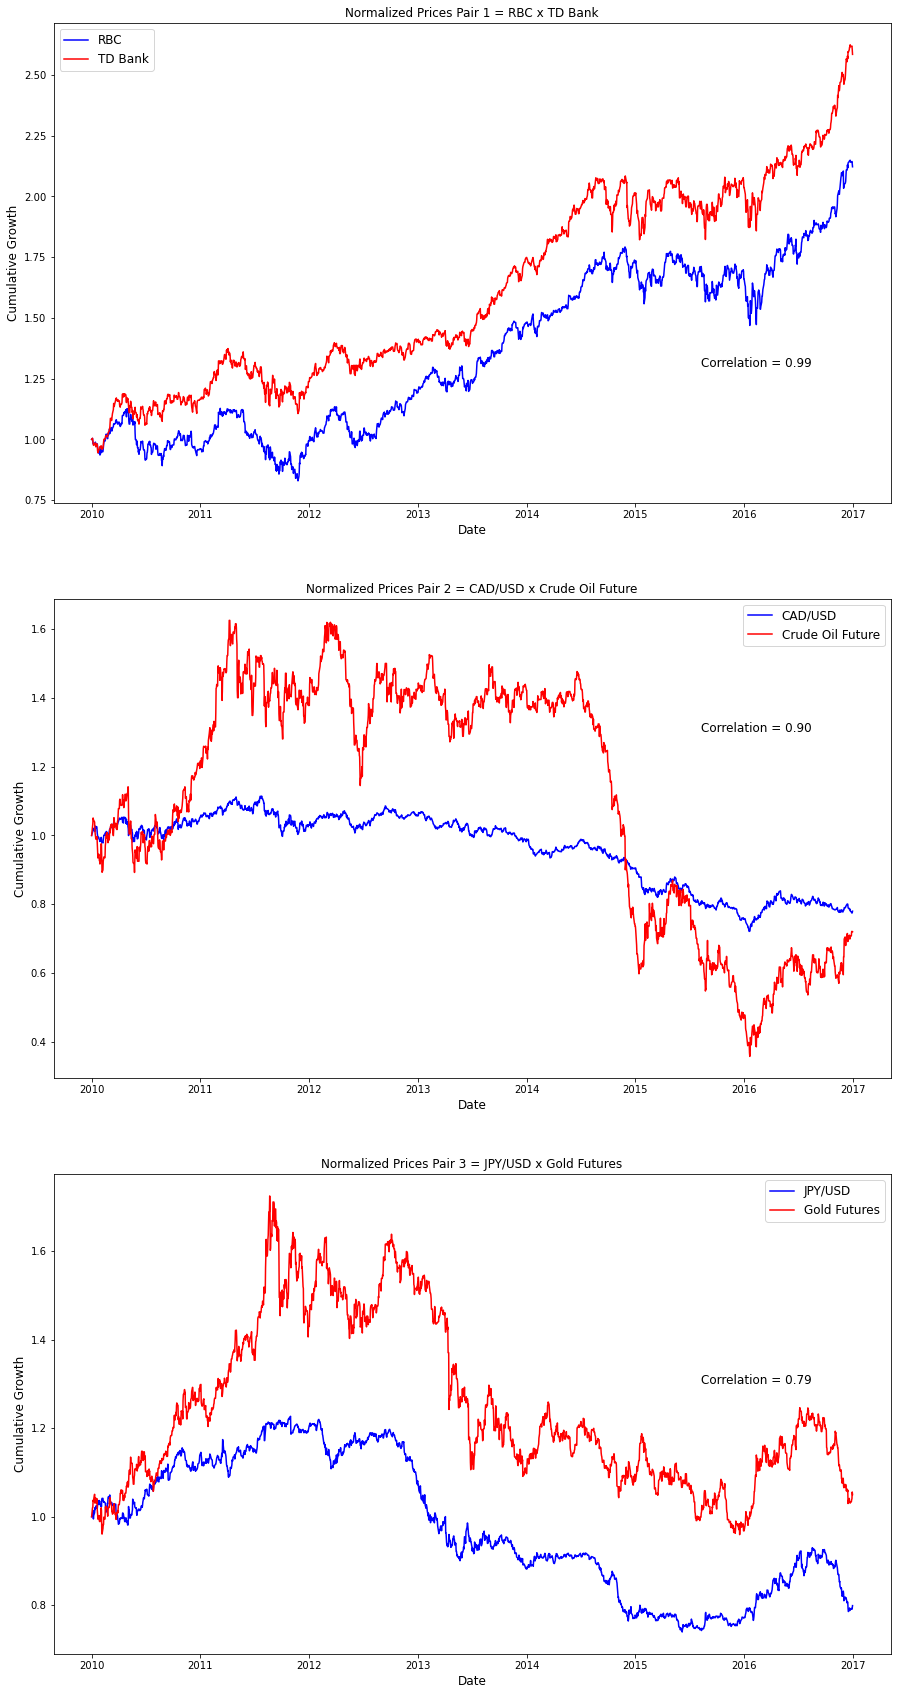

In [10]:
fig, ax = plt.subplots(nrows=len(pairs),ncols=1, figsize=(15,30),squeeze=True,)

for i, (T1,T2) in enumerate(pairs,1):
    corr = np.corrcoef(train[T1].values,train[T2].values,rowvar=False).min()
    ax[i-1].plot( train['Date'],train[T1]/train[T1].values[0],color='blue',label=labels_ticker[T1])
    ax[i-1].plot( train['Date'],train[T2]/train[T2].values[0],color='red',label=labels_ticker[T2])
    ax[i-1].set_title(f'Normalized Prices Pair {i} = {labels_ticker[T1]} x {labels_ticker[T2]}',fontsize=12)
    ax[i-1].set_xlabel(f'Date',fontsize=12)
    ax[i-1].set_ylabel(f'Cumulative Growth',fontsize=12)   
    ax[i-1].legend(loc='best',fontsize=12)
    ax[i-1].annotate(f"Correlation = {corr:.2f}",
                        xy=(dt.datetime(2016,8,10),1.3),
                        xytext=(dt.datetime(2015,8,10),1.3),fontsize=12)
    
plt.show()

### Pair 1: RBC Bank (RY.TO) and TD Bank (TD.TO)

The first pair we examine is between the two largest Canadian banks RBC and TD, and as depicted earlier their prices evolve at the same rate as shown by their almost perfect correlation. 

#### Engle Granger Fitting

We started by applying the Engle-Granger procedure to evaluate if cointegration exists between RBC and TD. The first results is shown on **Table 2** that regress RBC on TD as well as TD on RBC <br>
From **Table 2** we see that both regressions have highly significant coefficients.

In [66]:
eg = EngleGranger()

In [67]:
eg.fit(train['TD.TO'],train['RY.TO'])

In [68]:
eg.compare_ols.style.set_caption("Table 2: RY.TO and TD.TO OLS Regression Results").set_table_styles(styles)

**Table 3** is the ADF test for each equation, and notice that the spreads for both equations are stationary series due to their high T-Statistic. Equation 1 has a T-Statistic of -3.62 whereas equation 2 T-statistic is -3.66, both significant at 1% confidence level.<br>
Because Equation 2 ( $TD = f(RBC)$ ) has a larger absolute T-statistic I decide to move forward with this equation. Hence we move forward Equation 2 for the next steps

In [69]:
eg.compare_adf.style.set_caption("Table 3: RY.TO and TD.TO ADF Test Results").set_table_styles(styles)

,Equation 1:,RY.TO = TD.TO + Constant,,Equation 2:,TD.TO = RY.TO + Constant,
Null Hypothesis,Series has unit root,,,Series has unit root,,
T-Statistic,-3.623518,,,-3.661123,,
P-Value (MacKinnon),0.005327,,,0.004694,,
Optimal Lag,0,,,0,,
Confidence Level,1%,5%,10%,1%,5%,10%
Mackinnon Critical Value,-3.433567,-2.862961,-2.567527,-3.433567,-2.862961,-2.567527
Reject/Not Reject H0,Reject,Reject,Reject,Reject,Reject,Reject
Stationary/Non Stationary,Stationary,Stationary,Stationary,Stationary,Stationary,Stationary


**Table 4** exhibits the results for the error equation 2, dY refers to TD's first difference, dX is RBC first difference and Residual(-1) is the spread, mathematically this is the formulation

$$ \Delta TD_{t} = \Delta RBC_{t} - (1-\alpha)(TD - \hat\beta RBC - c)_{t-1} $$

We can see from the table that Residual(-1) p-value is much lower than 1% hence there is evidence of change in prices due to past difference between TD and RBC<br>
Therefore the final cointegration equation that will be used to design the trades is as follows:

$$ Spread_t = TD_t - 0.999 RBC - 0.022 $$

In [70]:
eg.ecm_results_table.style.set_caption("Table 4: Equation 2: TD.TO = RY.TO + Const Error Correction Model Results").set_table_styles(styles)

Given that the evaluated series has passed all the required statistical tests, we can proceed to fit the OU process to estimate the trading parameters to be utilized. <br> **Table 5** showcases all the relevant parameters with equilibrium ean of 0.012476 and standard deviation of 0.18, more than 10 higher than the equilibrium level. Another important parameter is the Half-life

In [71]:
eg.ou_process_summary.style.set_caption("Table 5: RY.TO and TD.TO OU Process Fitted Parameters").set_table_styles(styles)

,Value
OU Process Parameters,
$\mu_e$,0.012476
Half-Life (days),63.386585
$\sigma$,0.181998
$\theta$,2.755679


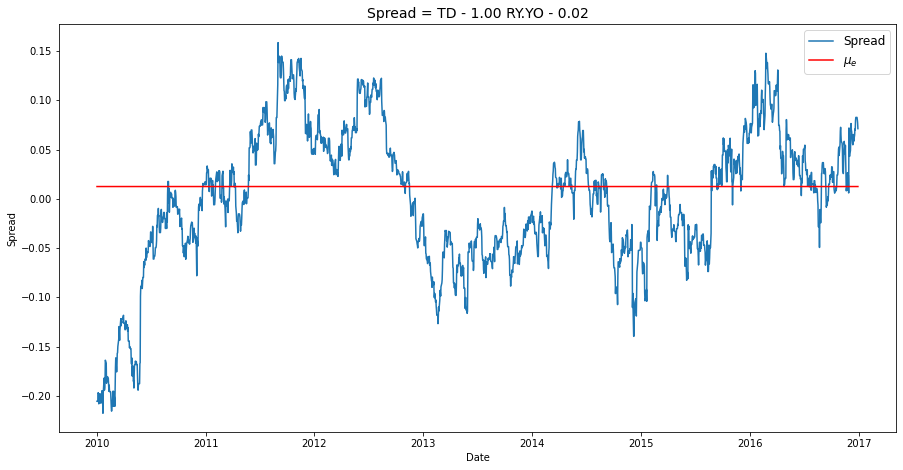

In [17]:
ou_parameters= eg.ou_process_params

coint_params= eg.cointegration_params

spread = eg.best_ols.residual.flatten()

fig= plt.figure(figsize=(15,7.5))
plt.plot(train.Date, spread,label='Spread')
plt.plot(train.Date, ou_parameters['mue']*np.ones(shape=train.Date.shape),color='red',label=r"$\mu_e$")
plt.title(f"Spread = TD - {coint_params[1]:.2f} RY.YO - {coint_params[0]:.2f}",fontsize=14)
plt.xlabel("Date")
plt.ylabel("Spread")
plt.legend(loc='best',fontsize=12)
plt.show()



#### Backtesting Pair Trading

In [18]:
z= [0.2,0.3,0.4,0.5,0.6,0.7]
z=np.array(z)

In [19]:
ptback_train = PairTradingBacktest(train.Date, 
                             train['RY.TO'],
                             train['TD.TO'],
                             coint_coeffs=coint_params.tolist(),
                             mue = ou_parameters['mue'],
                             sigma_eq=ou_parameters['sigma'],
                             zscores=z,
                             xy_label = ['RY.TO','TD.TO'],
                             tol=0.25)

In [20]:
ptback_valid = PairTradingBacktest(valid.Date, 
                             valid['RY.TO'],
                             valid['TD.TO'],
                             coint_coeffs=coint_params.tolist(),
                             mue = ou_parameters['mue'],
                             sigma_eq=ou_parameters['sigma'],
                             zscores=z,
                             xy_label = ['RY.TO','TD.TO'],
                             tol=0.25)

In [21]:
train_signals  = ptback_train.backtest()
valid_signals  = ptback_valid.backtest()


In [22]:
summary_train,trade_analysis_train = compute_risk_metrics(ptback_train.back_test_results,"XIU.TO")
summary_valid,trade_analysis_valid = compute_risk_metrics(ptback_valid.back_test_results,
                                                          "XIU.TO",
                                                          historical_tbl=ptback_train.back_test_results)

In [72]:
ptback_train.summary_tables().style.set_caption("Table 6: RY.TO and TD.TO P&L Results: Jan 1st, 2010 - Dec 31st, 2016").set_table_styles(styles)

,Strategy ID,Z-Score,# Trades,Annualized Return (%),Annualized Volatility (%),Cumulative Return (%),Avg # Days Open Position,Total Trading Days
0,1,0.200000,20.000000,17.119293,19.961850,114.636778,77.000000,1540
1,2,0.300000,9.000000,19.558349,20.893796,80.358593,117.777778,1060
2,3,0.400000,7.000000,21.072362,20.907375,76.936272,136.000000,952
3,4,0.500000,5.000000,19.355636,20.793530,59.731227,170.000000,850
4,5,0.600000,4.000000,19.135783,20.708165,53.846638,198.000000,792
5,6,0.700000,3.000000,23.841656,21.598017,50.020984,202.000000,606


In [73]:
summary_train.style.set_caption("Table 7: RY.TO and TD.TO Risk-Return Metrics: Jan 1st, 2010 - Dec 31st, 2016").set_table_styles(styles)

In [25]:
ptback_valid.summary_tables().style.set_caption("Table 8: RY.TO and TD.TO P&L Results: Feb 1st, 2017 - Feb 1st, 2019").set_table_styles(styles)

,Strategy ID,Z-Score,# Trades,Annualized Return (%),Annualized Volatility (%),Cumulative Return (%),Avg # Days Open Position,Total Trading Days
0,1,0.2,6.0,1.621025,8.235497,3.406802,107.166667,643
1,2,0.3,5.0,1.313571,8.219758,2.665661,123.800000,619
2,3,0.4,5.0,2.997666,8.269993,5.923673,119.200000,596
3,4,0.5,4.0,3.065352,8.258285,5.843537,143.750000,575
4,5,0.6,3.0,1.840199,8.469179,3.138001,173.333333,520
5,6,0.7,2.0,0.078708,8.351532,0.130901,255.500000,511


In [26]:
summary_valid.style.set_caption("Table 9: RY.TO and TD.TO Risk-Return Metrics: Feb 1st, 2017 - Feb 1st, 2019").set_table_styles(styles)

Value (%)                                            \
Strategy          Z-Score = 0.2 Z-Score = 0.3 Z-Score = 0.4 Z-Score = 0.5   
Metric                                                                      
Annual Return          1.621025      1.313571      2.997666      3.065352   
Annual Vol             8.235497      8.219758      8.269993      8.258285   
Cumulative Return      3.406802      2.665661      5.923673      5.843537   
Alpha (Annual)         1.991926      1.770715      3.430104      3.378201   
Sharpe               -11.015584    -14.763110      5.278625      6.051544   
Beta                   3.667833      4.452665      4.520008      5.427489   
Beta P-Value          36.271620     27.190821     27.017195     19.157191   
Alpha P-Value         72.719885     75.983593     56.288220     57.475869   
Max Drawdown           8.665791      7.866310      7.193113      7.193113   
1-Day VaR 99%          1.199150      1.198051      1.198853      1.196881   
10-Day VaR 99%         3.739188      3.743967      3.701656      3.693660   
1-Day ES 99%           1.374950      1.373514      1.375389      1.373167   
10-Day ES 99%          4.295115      4.298831      4.259911      4.251126   

                                               
Strategy          Z-Score = 0.6 Z-Score = 0.7  
Metric                                         
Annual Return          1.840199      0.078708  
Annual Vol             8.469179      8.351532  
Cumulative Return      3.138001      0.130901  
Alpha (Annual)         2.335778      0.557542  
Sharpe                -8.162011    -29.308613  
Beta                   5.744124      5.038985  
Beta P-Value          18.501295     24.052671  
Alpha P-Value         71.956935     93.142024  
Max Drawdown           7.193113      7.193113  
1-Day VaR 99%          1.232462      1.222184  
10-Day VaR 99%         3.838149      3.853256  
1-Day ES 99%           1.413250      1.400461  
10-Day ES 99%          4.409851      4.417016

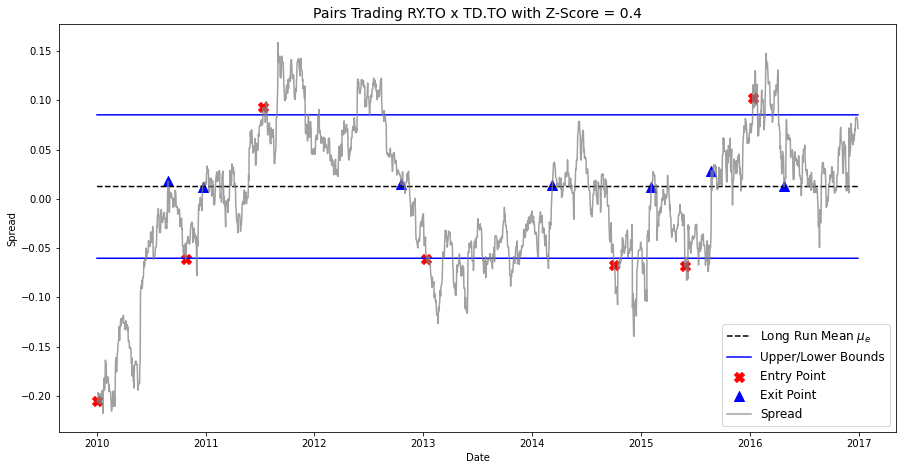

In [27]:
fig=ptback_train.plot_strategy(3)

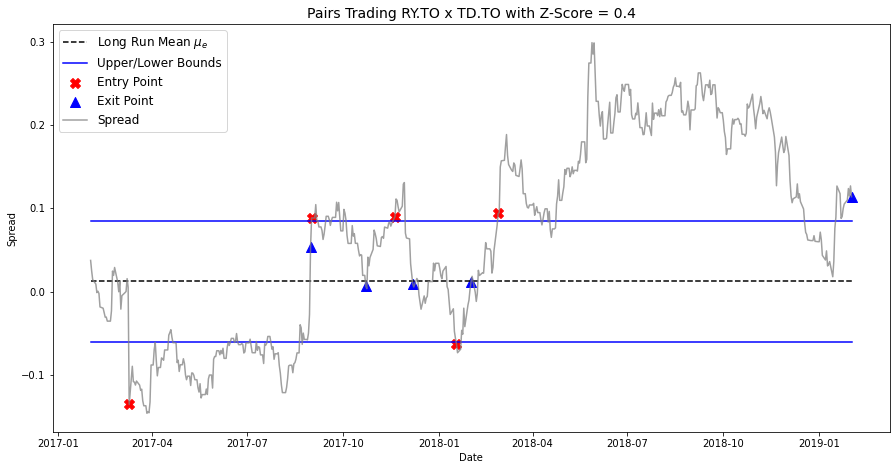

In [28]:
fig=ptback_valid.plot_strategy(3)

In [29]:
trade1 = trade_analysis_train.query("bounds_id==3")['analyzer'].values[0]


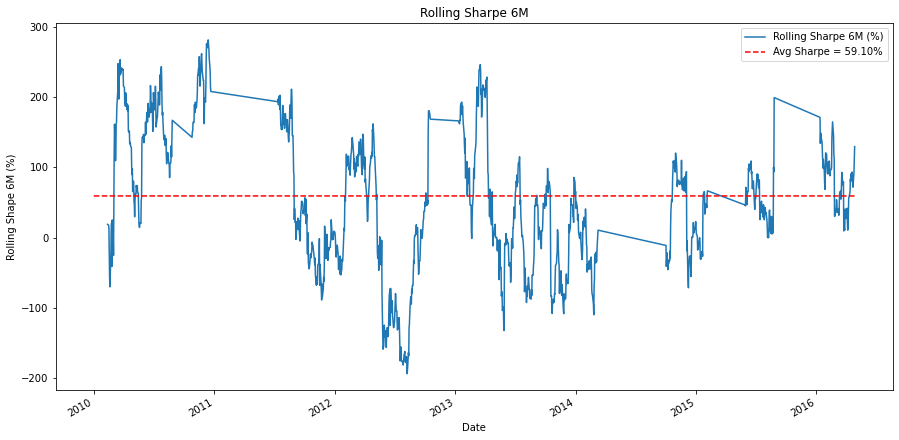

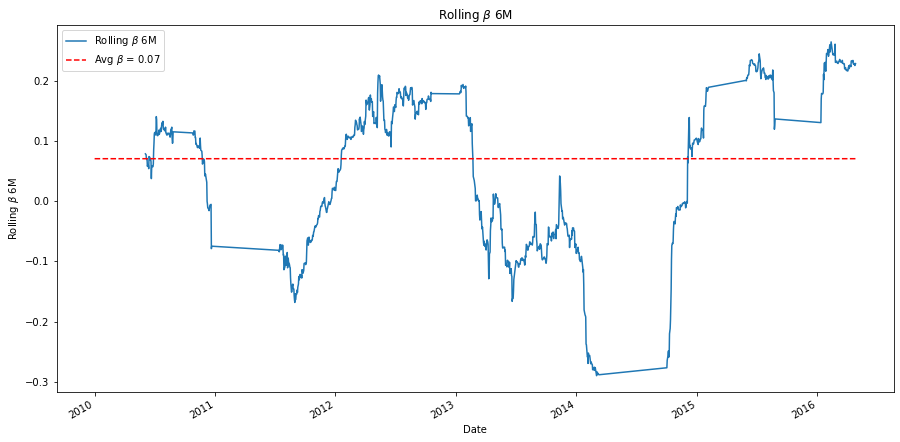

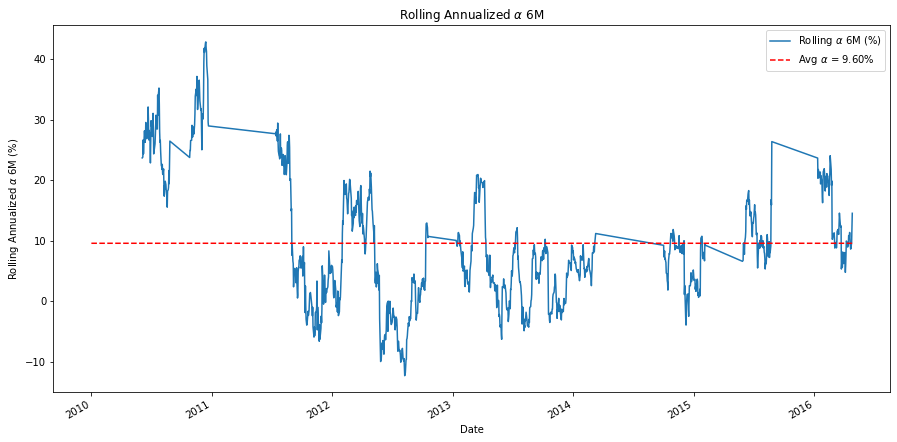

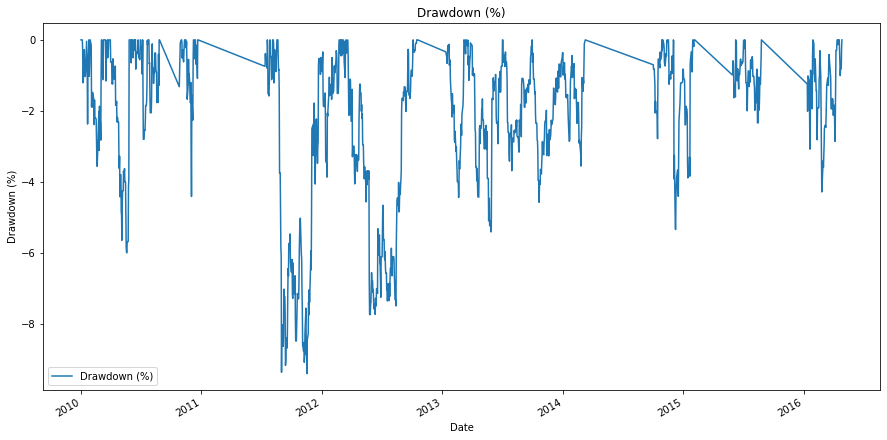

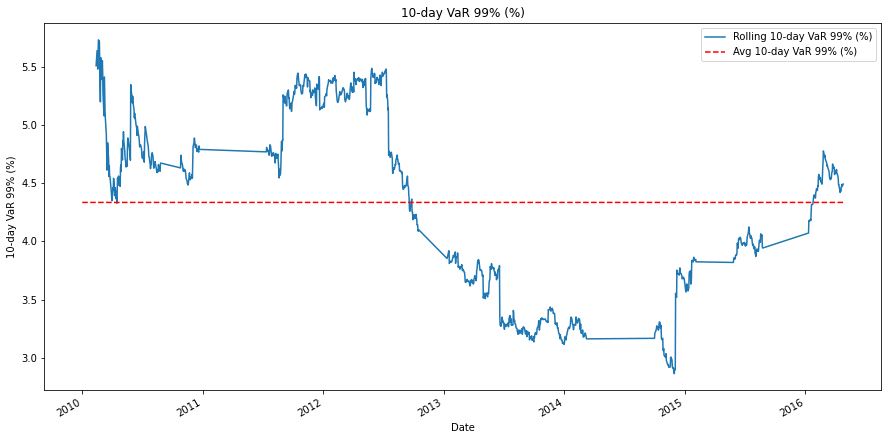

In [30]:
trade1plots=trade1.plots()

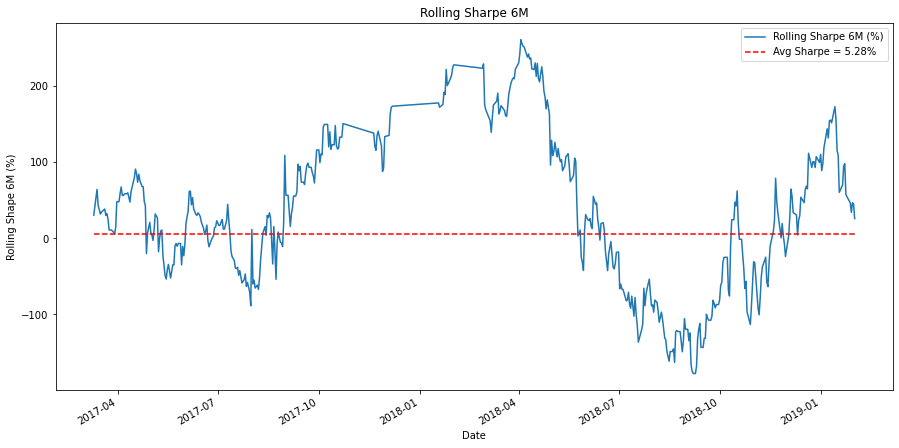

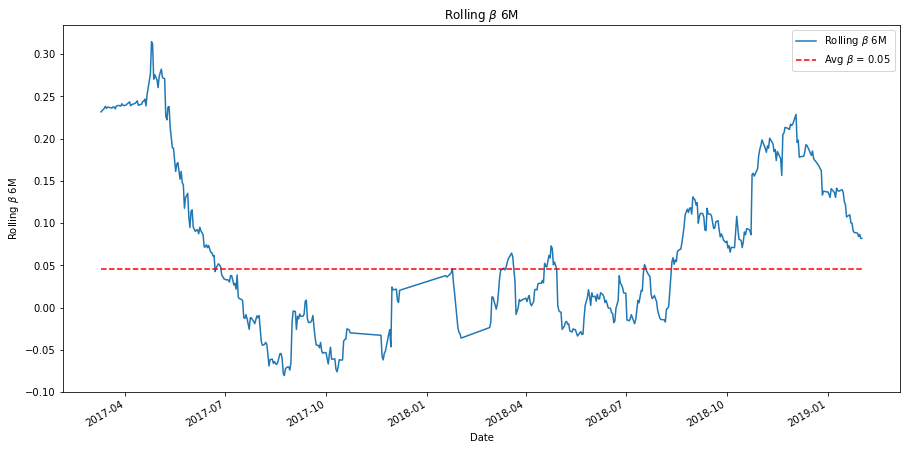

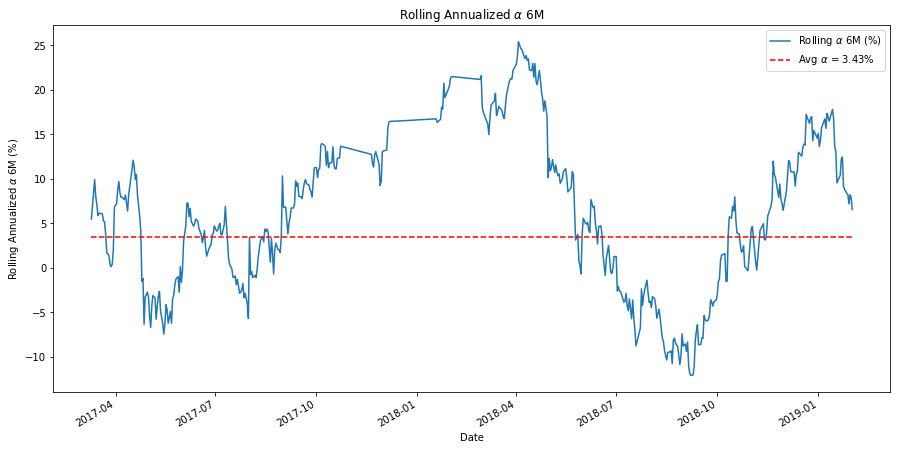

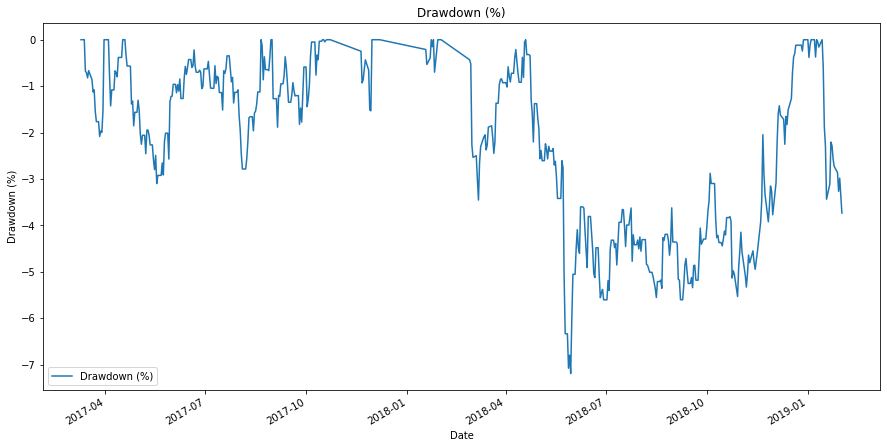

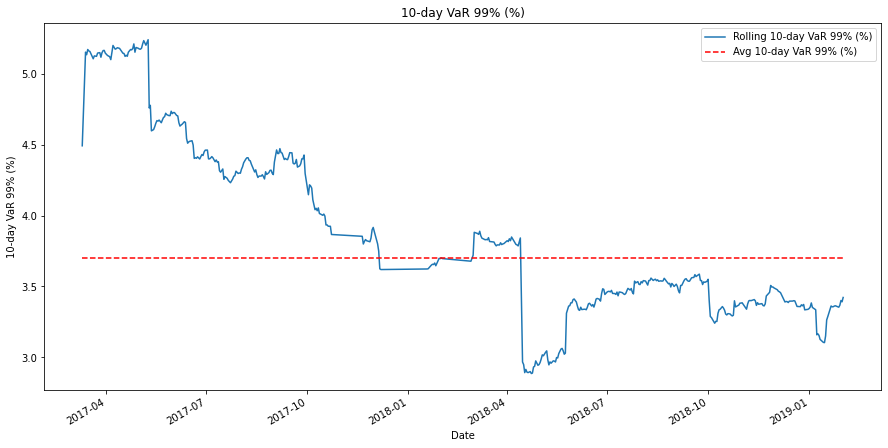

In [31]:
trade1 = trade_analysis_valid.query("bounds_id==3")['analyzer'].values[0]
trade1plots=trade1.plots()

In [32]:
ptback_test = PairTradingBacktest(test.Date, 
                             test['RY.TO'],
                             test['TD.TO'],
                             coint_coeffs=coint_params.tolist(),
                             mue = ou_parameters['mue'],
                             sigma_eq=ou_parameters['sigma'],
                             zscores=[0.4],
                             xy_label = ['RY.TO','TD.TO'],
                             tol=0.25)

In [33]:
ptback_test.backtest()

ptback_test.summary_tables()

,Strategy ID,Z-Score,# Trades,Annualized Return (%),Annualized Volatility (%),Cumulative Return (%),Avg # Days Open Position,Total Trading Days
0,1,0.4,4.0,3.022084,8.651625,2.330622,59.0,236


In [34]:
summary_test,trade_analysis_test = compute_risk_metrics(ptback_test.back_test_results,
                                                          historical_tbl=ptback_valid.back_test_results)

summary_test.applymap('{:.2f}'.format)


,Value (%)
Strategy,Z-Score = 0.4
Metric,
Annual Return,3.02
Annual Vol,8.65
Cumulative Return,2.33
Alpha (Annual),1.19
Sharpe,4.46
Beta,19.76
Beta P-Value,2.26
Alpha P-Value,90.34


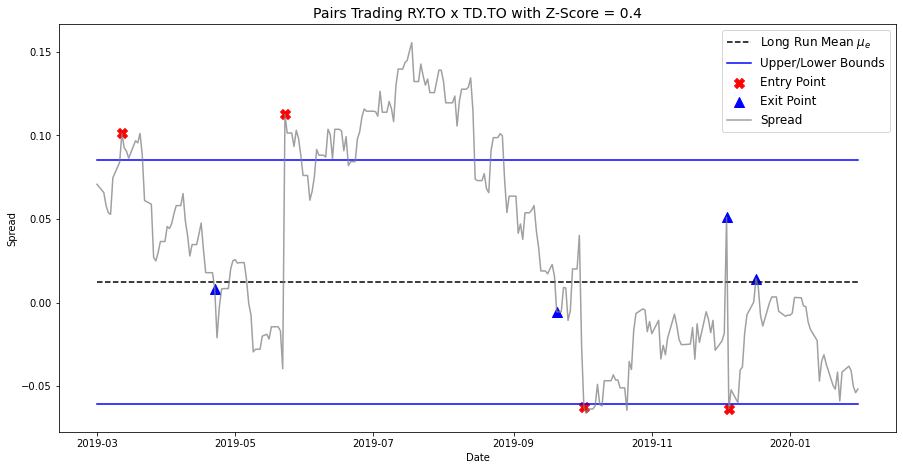

In [35]:
fig=ptback_test.plot_strategy(1)

### Pair 2: Japanese Yen (JPYUSD) x Gold Futures (GC=F)

#### Engle Granger Fitting

In [36]:
eg = EngleGranger()
eg.fit(train['JPYUSD=X'],train['GC=F'])

In [37]:

eg.compare_ols

Variable   GC=F                         Variable JPYUSD=X          \
Statistic             Beta P-Value     SE  T-Stat               Beta P-Value   
0          Constant  0.364   0.000  0.021  17.227  Constant    0.212   0.000   
1          JPYUSD=X  1.067   0.000  0.018  58.791      GC=F    0.590   0.000   

                          
Statistic     SE  T-Stat  
0          0.016  13.102  
1          0.010  58.791

In [38]:
eg.compare_adf

,Equation 1:,GC=F = JPYUSD=X + Constant,,Equation 2:,JPYUSD=X = GC=F + Constant,
Null Hypothesis,Series has unit root,,,Series has unit root,,
T-Statistic,-3.296319,,,-2.852289,,
P-Value (MacKinnon),0.015044,,,0.051184,,
Optimal Lag,24,,,25,,
Confidence Level,1%,5%,10%,1%,5%,10%
Mackinnon Critical Value,-3.433567,-2.862961,-2.567527,-3.433567,-2.862961,-2.567527
Reject/Not Reject H0,Not Reject,Reject,Reject,Not Reject,Not Reject,Reject
Stationary/Non Stationary,Non Stationary,Stationary,Stationary,Non Stationary,Non Stationary,Stationary


In [39]:
eg.ecm_results_table

dY                       
Statistic       Beta P-Value     SE  T-Stat
Variable                                   
dX             0.175   0.002  0.055   3.157
Residual(-1)  -0.010   0.000  0.003  -3.989

In [40]:

eg.best_ols.table_params_out

GC=F                       
Statistic   Beta P-Value     SE  T-Stat
Variable                               
Constant   0.364   0.000  0.021  17.227
JPYUSD=X   1.067   0.000  0.018  58.791

In [41]:
eg.ou_process_summary

,Value
OU Process Parameters,
$\mu_e$,0.016859
Half-Life (days),74.867917
$\sigma$,0.376355
$\theta$,2.333083


In [42]:
coint_params= eg.cointegration_params

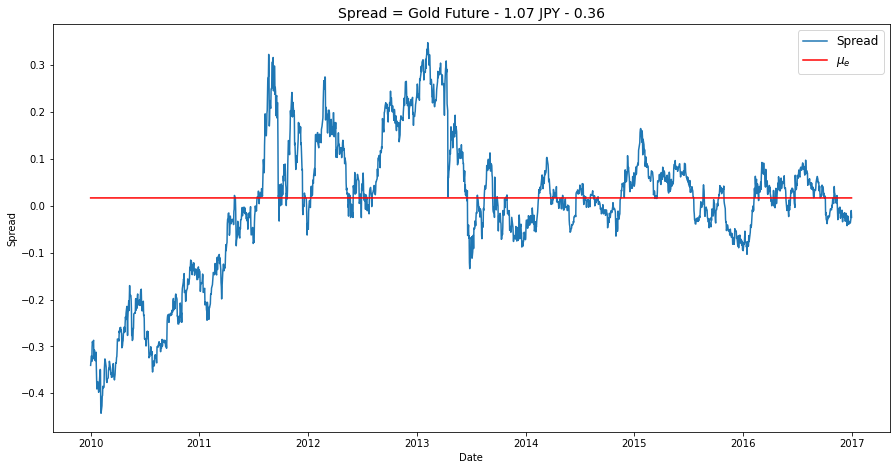

In [43]:
ou_parameters= eg.ou_process_params
coint_params= eg.cointegration_params
spread = eg.best_ols.residual.flatten()

fig= plt.figure(figsize=(15,7.5))
plt.plot(train.Date, spread,label='Spread')
plt.plot(train.Date, ou_parameters['mue']*np.ones(shape=train.Date.shape),color='red',label=r"$\mu_e$")
plt.title(f"Spread = Gold Future - {coint_params[1]:.2f} JPY - {coint_params[0]:.2f}",fontsize=14)
plt.xlabel("Date")
plt.ylabel("Spread")
plt.legend(loc='best',fontsize=12)
plt.show()



In [44]:
ptback_train = PairTradingBacktest(train.Date, 
                             train['JPYUSD=X'],
                             train['GC=F'],
                             coint_coeffs=coint_params.tolist(),
                             mue = ou_parameters['mue'],
                             sigma_eq=ou_parameters['sigma'],
                             zscores=z,
                             xy_label = ['JPYUSD','GC'],
                             tol=0.25)

ptback_valid = PairTradingBacktest(valid.Date, 
                             valid['JPYUSD=X'],
                             valid['GC=F'],
                             coint_coeffs=coint_params.tolist(),
                             mue = ou_parameters['mue'],
                             sigma_eq=ou_parameters['sigma'],
                             zscores=z,
                             xy_label = ['JPYUSD','GC'],
                             tol=0.25)

In [45]:
train_backtest=ptback_train.backtest()
valid_backtest=ptback_valid.backtest()



In [46]:
summary_train,trade_analysis_train = compute_risk_metrics(ptback_train.back_test_results,"^NN225")
summary_valid,trade_analysis_valid = compute_risk_metrics(ptback_valid.back_test_results,
                                                          "^NN225",
                                                          historical_tbl=ptback_train.back_test_results)

In [47]:
ptback_train.summary_tables()

,Strategy ID,Z-Score,# Trades,Annualized Return (%),Annualized Volatility (%),Cumulative Return (%),Avg # Days Open Position,Total Trading Days
0,1,0.2,20.0,17.119293,19.961850,114.636778,77.000000,1540
1,2,0.3,9.0,19.558349,20.893796,80.358593,117.777778,1060
2,3,0.4,7.0,21.072362,20.907375,76.936272,136.000000,952
3,4,0.5,5.0,19.355636,20.793530,59.731227,170.000000,850
4,5,0.6,4.0,19.135783,20.708165,53.846638,198.000000,792
5,6,0.7,3.0,23.841656,21.598017,50.020984,202.000000,606


In [48]:
summary_train

Value (%)                                            \
Strategy          Z-Score = 0.2 Z-Score = 0.3 Z-Score = 0.4 Z-Score = 0.5   
Metric                                                                      
Annual Return         17.119293     19.558349     21.072362     19.355636   
Annual Vol            19.961850     20.893796     20.907375     20.793530   
Cumulative Return    114.636778     80.358593     76.936272     59.731227   
Alpha (Annual)        17.803880     20.139353     21.145661     19.274399   
Sharpe                70.910225     77.882200     83.684626     76.746172   
Beta                   0.040365    -10.418381     -7.052125     -6.043313   
Beta P-Value          99.256608      5.407362     23.243603     32.782406   
Alpha P-Value          5.041780      8.011467      8.136040     13.304321   
Max Drawdown          20.115238     17.573266     16.459400     16.160612   
1-Day VaR 99%          2.854742      2.982405      2.979395      2.968485   
10-Day VaR 99%         8.544815      8.887597      8.843881      8.848865   
1-Day ES 99%           3.280859      3.428416      3.425695      3.412356   
10-Day ES 99%          9.892315     10.298008     10.255208     10.252507   

                                               
Strategy          Z-Score = 0.6 Z-Score = 0.7  
Metric                                         
Annual Return         19.135783     23.841656  
Annual Vol            20.708165     21.598017  
Cumulative Return     53.846638     50.020984  
Alpha (Annual)        19.847979     23.664414  
Sharpe                76.042282     91.116677  
Beta                   3.178233     18.842919  
Beta P-Value          63.302121      1.446259  
Alpha P-Value         13.427589     13.074335  
Max Drawdown          16.160612     13.416767  
1-Day VaR 99%          2.956778      3.071070  
10-Day VaR 99%         8.817331      9.068581  
1-Day ES 99%           3.398826      3.532113  
10-Day ES 99%         10.215210     10.526529

In [49]:
ptback_valid.summary_tables()

,Strategy ID,Z-Score,# Trades,Annualized Return (%),Annualized Volatility (%),Cumulative Return (%),Avg # Days Open Position,Total Trading Days
0,1,0.2,2.0,1.285198,10.414184,1.351944,166.0,332
1,2,0.3,1.0,5.737122,10.540438,5.713718,318.0,318


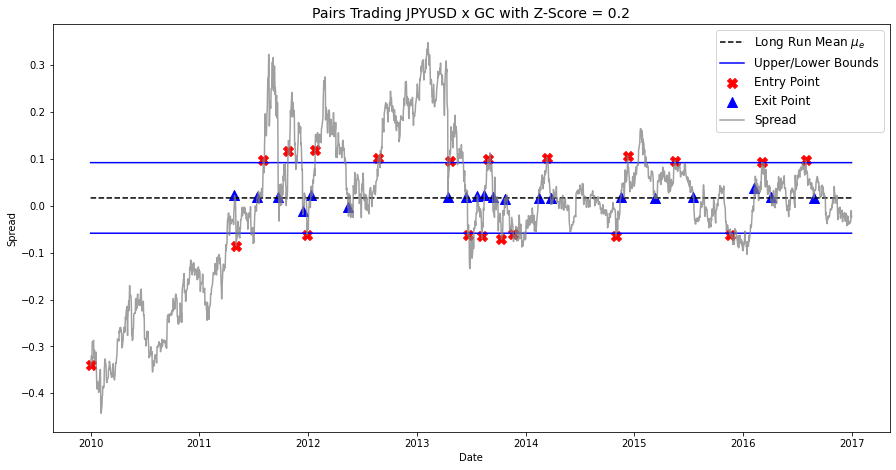

In [50]:
fig=ptback_train.plot_strategy(1)


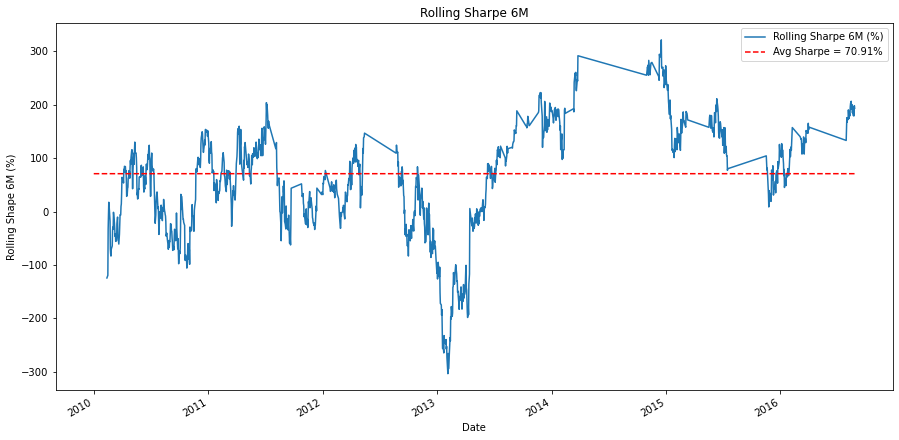

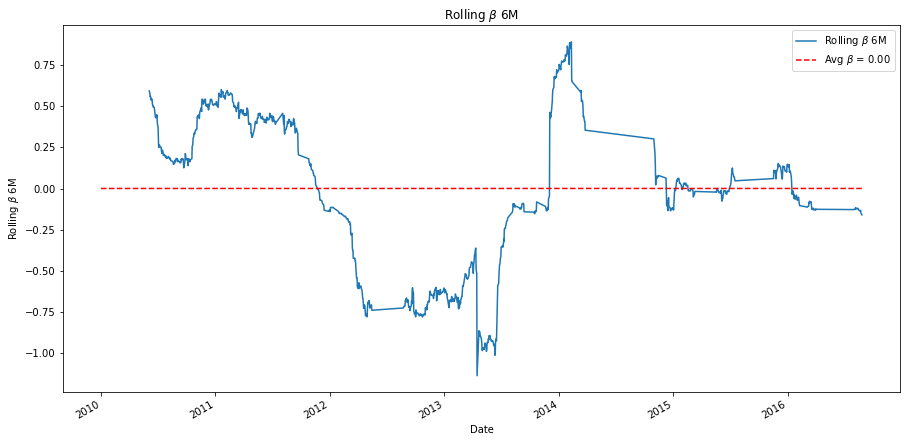

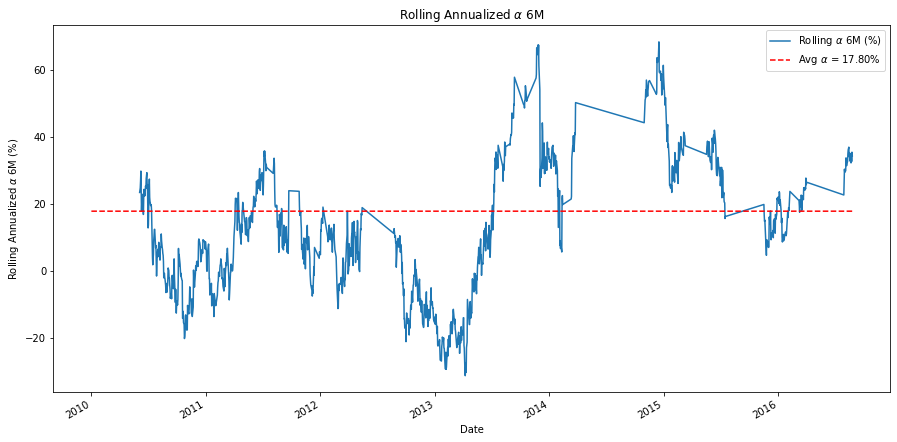

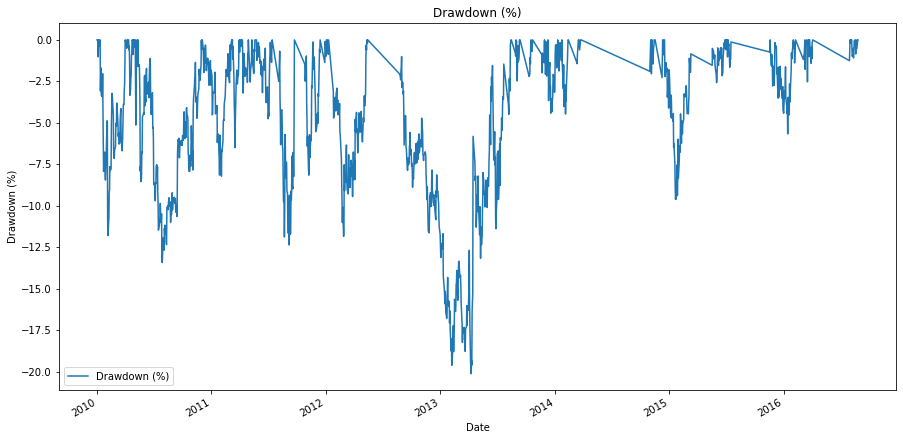

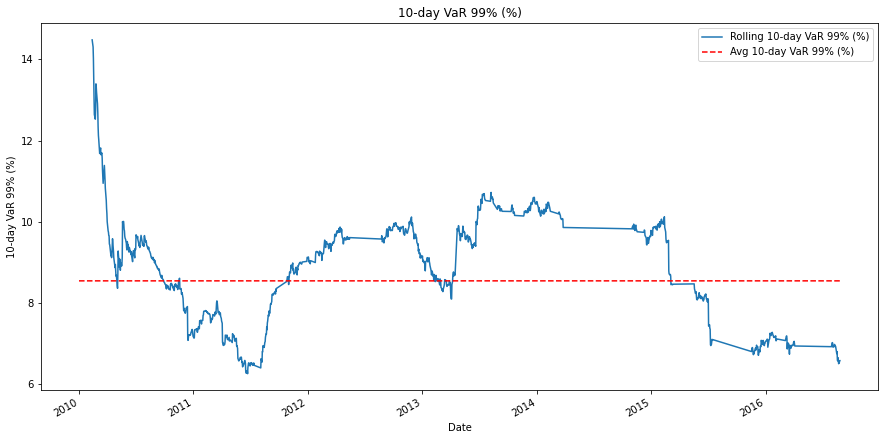

In [51]:
trainanalyzer=trade_analysis_train.query("bounds_id==1")['analyzer'][0]
figs=trainanalyzer.plots()


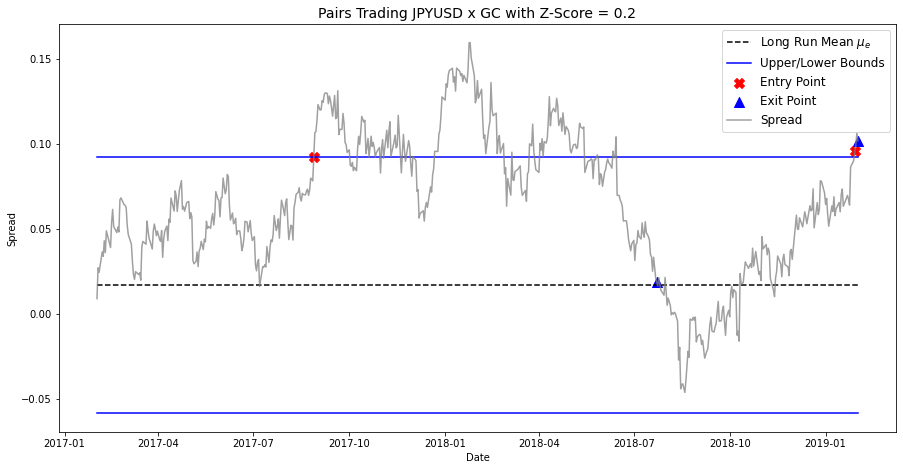

In [52]:
fig=ptback_valid.plot_strategy(1)


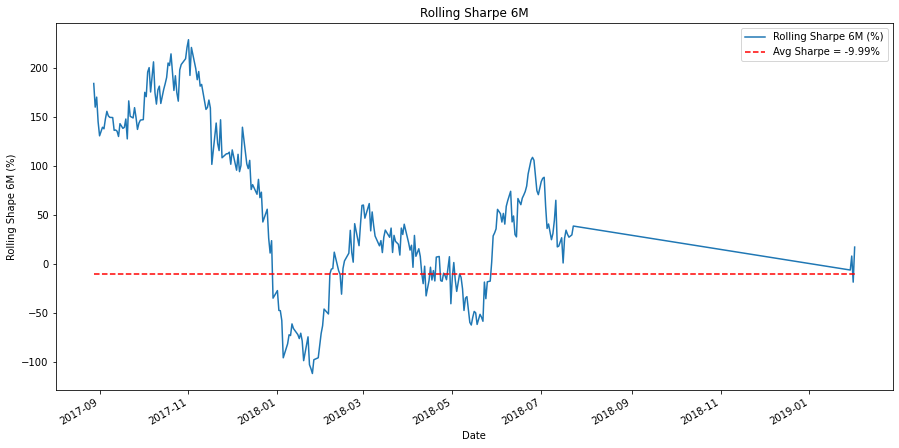

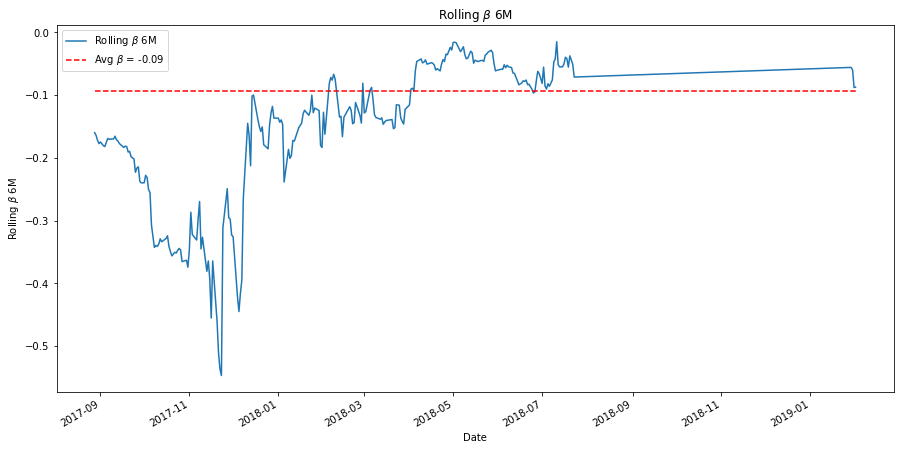

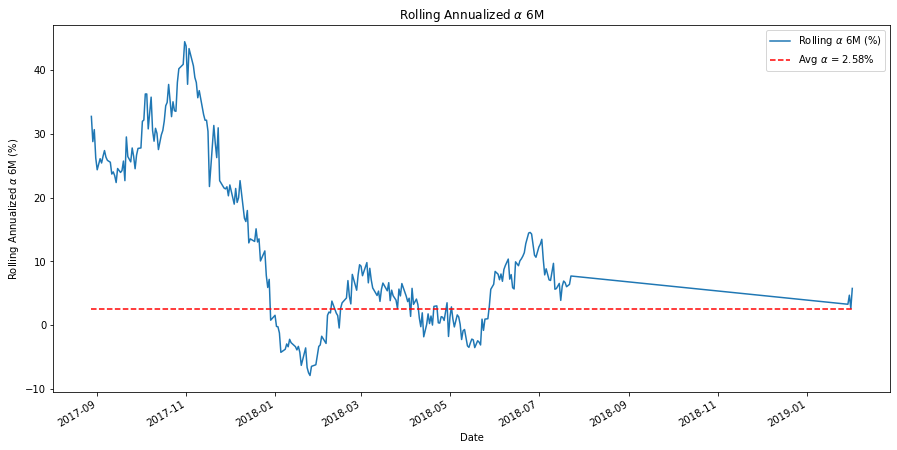

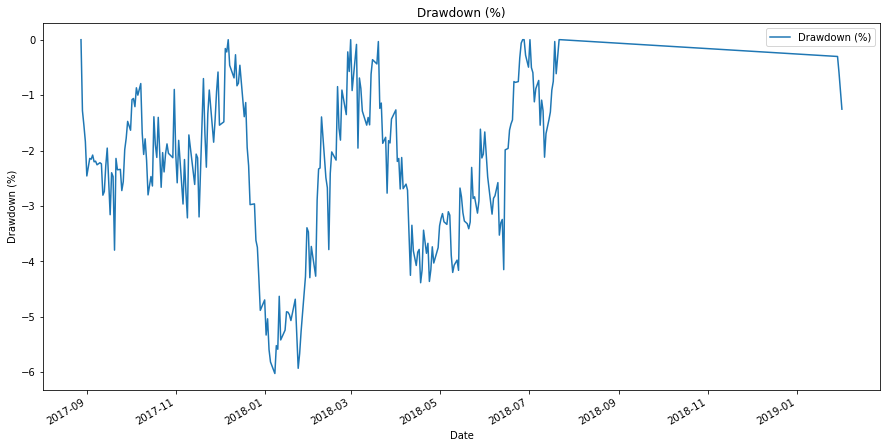

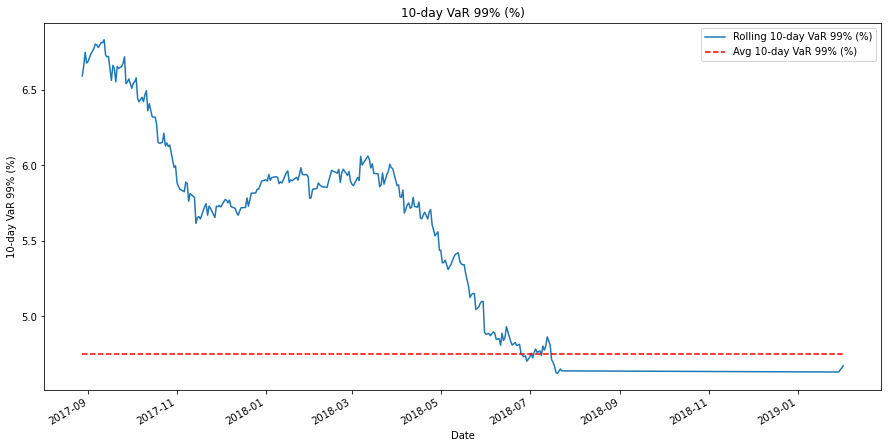

In [53]:
valanalyzer=trade_analysis_valid.query("bounds_id==1")['analyzer'][0]
figs=valanalyzer.plots()


### Pair 3: Canadian Dollar (CADUSD) x Oil Futures (BZ=F)

#### Engle Granger Fitting

In [54]:
eg = EngleGranger()
eg.fit(train['CADUSD=X'],train['BZ=F'])

In [55]:
eg.compare_ols

Variable    BZ=F                          Variable CADUSD=X  \
Statistic              Beta P-Value     SE   T-Stat               Beta   
0          Constant  -1.408   0.000  0.025  -55.691  Constant    0.626   
1          CADUSD=X   2.528   0.000  0.028   91.472      BZ=F    0.318   

                                   
Statistic P-Value     SE   T-Stat  
0           0.000  0.003  192.742  
1           0.000  0.003   91.472

In [56]:
eg.compare_adf

,Equation 1:,BZ=F = CADUSD=X + Constant,,Equation 2:,CADUSD=X = BZ=F + Constant,
Null Hypothesis,Series has unit root,,,Series has unit root,,
T-Statistic,-2.373115,,,-2.155834,,
P-Value (MacKinnon),0.149469,,,0.222664,,
Optimal Lag,2,,,2,,
Confidence Level,1%,5%,10%,1%,5%,10%
Mackinnon Critical Value,-3.433567,-2.862961,-2.567527,-3.433567,-2.862961,-2.567527
Reject/Not Reject H0,Not Reject,Not Reject,Not Reject,Not Reject,Not Reject,Not Reject
Stationary/Non Stationary,Non Stationary,Non Stationary,Non Stationary,Non Stationary,Non Stationary,Non Stationary


In [57]:
eg.ecm_results_table

dY                       
Statistic       Beta P-Value     SE  T-Stat
Variable                                   
dX             0.646   0.000  0.066   9.736
Residual(-1)  -0.007   0.003  0.002  -2.980

In [64]:
!jupyter nbconvert --to html --no-prompt --TemplateExporter.exclude_input=True CQF_PairsTrading.ipynb


[NbConvertApp] Converting notebook CQF_PairsTrading.ipynb to html
[NbConvertApp] Writing 2587144 bytes to CQF_PairsTrading.html
